In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from scipy.interpolate import griddata
from sklearn.preprocessing import MinMaxScaler

In [5]:
from model.NetworkGraph import CompleteGraph
from model.NodeClass import Node
from model.LinkClass import Link

In [6]:
potentially_aggregation_nodes = [
    "09-00023",
    # "09-03083",
    "09-04361",
    # "09-03163",
    "09-00195",
    "09-03649",
]

In [7]:
graph = CompleteGraph.of_sources_only_core_nodes("../Passion_Xtreme_III.mat", "../NameTypes.xlsx", core_nodes=potentially_aggregation_nodes)

Discarded nodes: 329
Discarded links: 0
Links: 16
Nodes: 17

*-*-* Printing information about the imported network *-*-*

Num nodes: 17
Num links: 16
Num HL4: 0
Num HL5: 0
Average distance: 17.67
Max distance (km): 52.25
Min distance (km): 2.75
Average degree: 3.47
Min degree: 2
Max degree: 6
Average degree HL4: nan
Average degree HL5: nan
Total bidirectional link length (km): 282.74


/home/elig/.cache/pypoetry/virtualenvs/pof-simulation-python-Sj3CBpnm-py3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/elig/.cache/pypoetry/virtualenvs/pof-simulation-python-Sj3CBpnm-py3.11/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


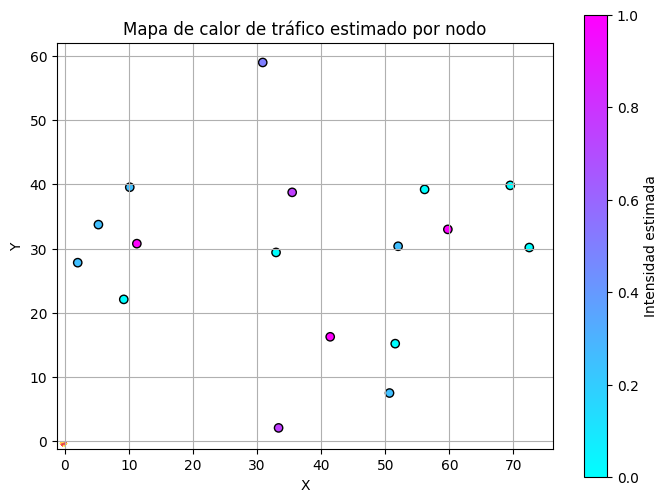

In [8]:
x, y = Node.obtain_x_y_vectors(graph.nodes)
degree = Node.obtain_degree_vector(graph.nodes)

df = pd.DataFrame({'x': x, 'y': y, 'degree': degree})

# Calcular densidad local: cuántos vecinos en cierto radio
tree = KDTree(df[['x', 'y']])
radio = 0.5  # puedes ajustar esto
densidad = []

for i in range(len(df)):
    vecinos = tree.query_ball_point([df.loc[i, 'x'], df.loc[i, 'y']], r=radio)
    densidad.append(len(vecinos) - 1)  # excluye el propio nodo

df['densidad'] = densidad

# Estimar intensidad de tráfico
alpha = 1.0
beta = 1.0
df['intensidad'] = alpha * df['densidad'] + beta * df['degree']


# Normalizar para visualización
scaler = MinMaxScaler()
df['intensidad_norm'] = scaler.fit_transform(df[['intensidad']])



# Crear grid para mapa de calor
grid_x, grid_y = np.mgrid[0:100:200j, 0:100:200j]
grid_z = griddata(df[['x', 'y']], df['intensidad_norm'], (grid_x, grid_y), method='cubic')

# Visualizar mapa de calor + nodos
plt.figure(figsize=(8, 6))
plt.imshow(grid_z.T, extent=(-1.25, 1.25, -1.25, 1.25), origin='lower', cmap='hot', alpha=0.7)
plt.scatter(df['x'], df['y'], c=df['intensidad_norm'], cmap='cool', edgecolor='k')
plt.colorbar(label='Intensidad estimada')
plt.title('Mapa de calor de tráfico estimado por nodo')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()


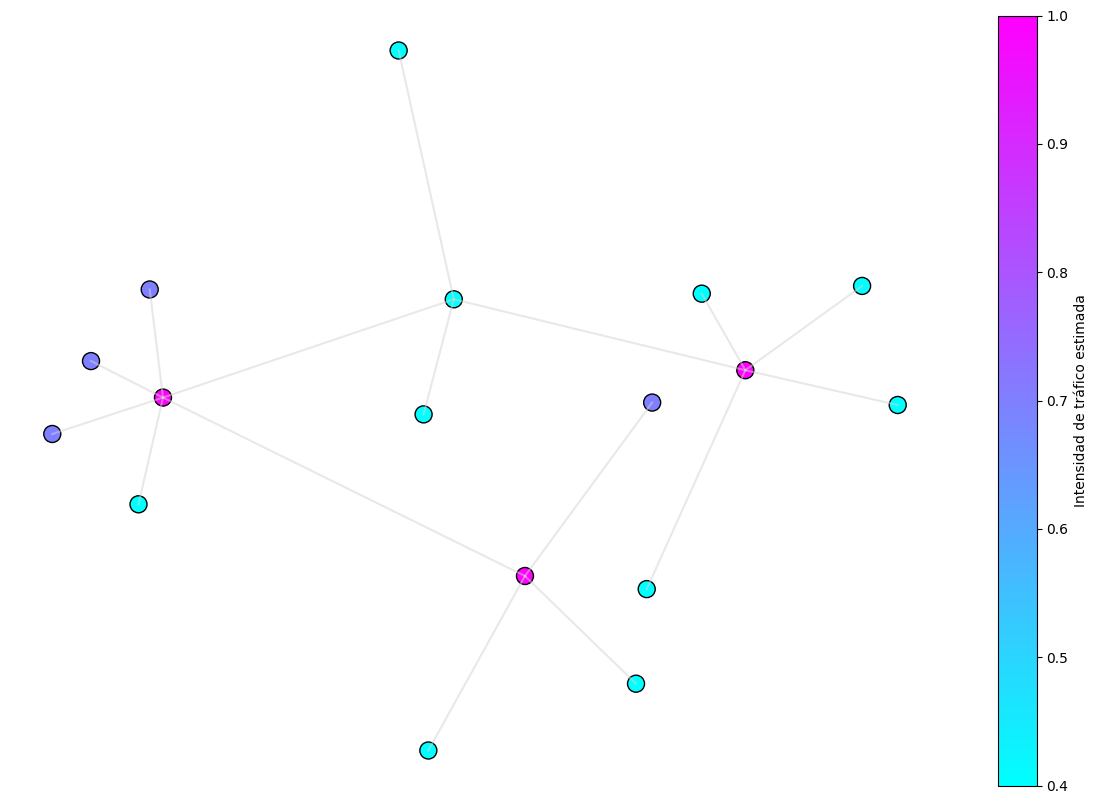

In [40]:
x, y = Node.obtain_x_y_vectors(graph.nodes)
classifications = [
    0.4 if node.traffic_profile == "low" 
    else 0.7 if node.traffic_profile == "medium" 
    else 1.0 
    for node in graph.nodes
]

fig, ax = plt.subplots(figsize=(15, 10))


# Pintar enlaces de forma muy ligera
for link in graph.links:
    ax.plot([link.a.pos[0], link.b.pos[0]], [link.a.pos[1], link.b.pos[1]], color='lightgrey', alpha=0.5)


# Crear grid para mapa de calor
grid_x, grid_y = np.mgrid[0:100:200j, 0:100:200j]
grid_z = griddata(np.column_stack((x, y)), classifications, (grid_x, grid_y), method='cubic')

# Visualizar nodos
scatter = ax.scatter(x, y, c=classifications, cmap='cool', edgecolor='k', s=150)

# Agregar barra de color sin usar imshow
cbar = fig.colorbar(scatter, ax=ax, label='Intensidad de tráfico estimada')

# Configurar el eje
ax.set_axis_off()


plt.show()

In [10]:
graph_2 = graph.model_copy()